In [17]:
import os
import json
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from libs.helper import get_mfcc_features

In [5]:
data_dir = './LibriSpeech'
info_path = './data/info.csv'

assert os.path.exists(data_dir), 'Data directory not found'
assert os.path.exists(info_path), 'Info file not found, please run preprocess.ipynb first'
info = pd.read_csv(info_path)

In [6]:
class LibriSpeechData(Dataset):
    def __init__(self, info, metadata=None, data_dir='./LibriSpeech', max_len=None):
        if metadata is None:
            self.info = info
        else:
            self.info = info[info['speaker_id'].isin(metadata)]
        self.data_dir = data_dir
        self.max_len = max_len

        self.sex_dict = {'M': 0, 'F': 1}

    def __len__(self):
        return len(self.info)

    def __getitem__(self, idx):
        sample = self.info.iloc[idx]
        
        speaker_id = sample['speaker_id']
        transcript = sample['transcript']
        sex = sample['sex']

        audio_path = f'{self.data_dir}/{sample["audio_path"]}'
        mfcc_features = get_mfcc_features(audio_path)

        if self.max_len is not None:
            if mfcc_features.shape[-1] < self.max_len:
                mfcc_features = np.pad(mfcc_features, ((0, 0), (0, self.max_len - mfcc_features.shape[-1])), 'constant')
            else:
                mfcc_features = mfcc_features[:, :self.max_len]

        label = self.sex_dict[sex]
        return mfcc_features, label, (speaker_id, transcript)

In [7]:
dataset = LibriSpeechData(info, data_dir=data_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

### MFCC Features

Mel-Frequency Cepstral Coefficients (MFCCs) are widely used in speech and audio processing to represent the spectral characteristics of a signal. 

The 13 MFCC features refer to the first 13 coefficients extracted from the MFCC representation of an audio signal.

MFCCs vs. Raw Spectrograms:
* A raw spectrogram captures exact frequency details.
* MFCCs extract the overall shape (spectral envelope) without fine-grained variations.

In [8]:
for mfcc_features, label, (speaker_id, transcript) in tqdm.tqdm(dataloader):
    mfcc_features = mfcc_features.squeeze(0)
    break

  0%|          | 0/2703 [00:00<?, ?it/s]


Sample MFCC features

* MFCC0 is often associated with the loudness of the audio (represented in log scale)
    $$
    MFCC0 = \log\sum_i S[i]
    $$
    , where $S[i]$ is the power spectrum in the i-th Mel filter.
    * If the singal has near-zero energy, MFCC0 will approaches a large negative value
* MFCC1-12: Spectral Shape (**formant information**)
    * Derives from the the **spectral envelope** of speech
    * Represent how energy is distributed across different frequency bands

Terms: 
1. Formant Information: Peaks in the frequency spectrum of speech that correspond to resonant frequencies of the vocal tract.
    * Male voices often has a lower formants (~300-800 Hz for F1, ~800-2000 Hz for F2) compare to female voices (~350-900 Hz for F1, ~900-2500 Hz for F2)
2. Spectral Envelope: The smooth curve that outlines the peaks of the frequency spectrum of speech, which shows an overall shape of the frequency distribution.

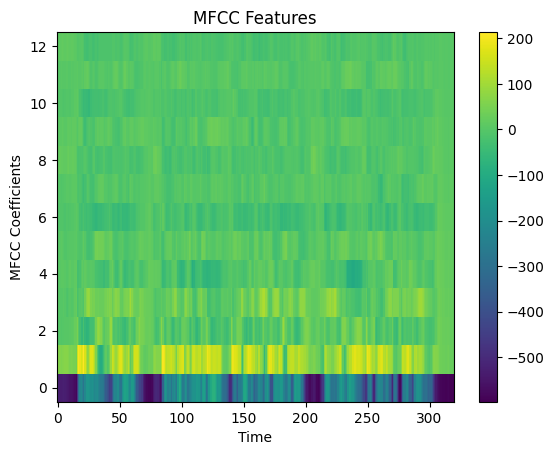

In [9]:
plt.imshow(mfcc_features.numpy(), aspect='auto', origin='lower', interpolation='none')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.title('MFCC Features')
plt.show()

### Data Analysis

#### 1. Average MFCC

Since the MFCC graph is related to the recording's duration, we can calculate the average MFCC feature to obtain a compact representation of the overall spectral characteristics of the audio. 

This helps in tasks such as speaker identification, emotion recognition, and music classification, where a fixed-size feature vector is needed instead of a time-dependent representation.

In [10]:
average_mfccs = []
gender_labels = []
speaker_ids = []
for mfcc_features, label, (speaker_id, transcript) in tqdm.tqdm(dataloader):
    average_mfccs.append(mfcc_features.numpy().squeeze(0).mean(axis=-1))
    gender_labels.append(label.item())
    speaker_ids.append(speaker_id.item())

average_mfccs = np.array(average_mfccs)
gender_labels = np.array(gender_labels)
speaker_ids = np.array(speaker_ids)

avg_mfcc_df = {
    'speaker_id': speaker_ids,
    'gender_labels': gender_labels,
    'mfccs': average_mfccs.tolist()
}

avg_mfcc_df = pd.DataFrame(avg_mfcc_df)

100%|██████████| 2703/2703 [00:53<00:00, 50.61it/s] 


In [11]:
print("Number of speakers:", len(avg_mfcc_df['speaker_id'].unique()))
print(" - male (0):", len(avg_mfcc_df[avg_mfcc_df['gender_labels'] == 0]['speaker_id'].unique()))
print(" - female (1):", len(avg_mfcc_df[avg_mfcc_df['gender_labels'] == 1]['speaker_id'].unique()))
print("")
print("Number of samples", len(avg_mfcc_df))
print(avg_mfcc_df.head())

Number of speakers: 40
 - male (0): 20
 - female (1): 20

Number of samples 2703
   speaker_id  gender_labels  \
0         174              0   
1         251              0   
2        2086              0   
3         777              0   
4        3536              1   

                                               mfccs  
0  [-252.55328369140625, 73.31140899658203, -5.13...  
1  [-337.5335693359375, 123.83642578125, 21.20853...  
2  [-326.830810546875, 108.02312469482422, -11.95...  
3  [-366.24652099609375, 104.45227813720703, 5.39...  
4  [-273.83648681640625, 82.17957305908203, -8.20...  


#### 2. Preprocess

MFCC0 represents the loudness of speech and can be on a different scale compared to other MFCC features. Additionally, its variance across different audio samples can be significantly high. Therefore, applying normalization to each MFCC feature is necessary to better observe distribution differences and ensure fair comparisons. In here, we use z-score normalization.

In [12]:
scaler = StandardScaler()
mfcc_norm = scaler.fit_transform(avg_mfcc_df['mfccs'].values.tolist())
mean = scaler.mean_
std = np.sqrt(scaler.var_)
print("Normalization Mean: ", mean)
print("Normalization Std: ", std)

Normalization Mean:  [-3.13638786e+02  8.49510116e+01 -2.81166738e+00  2.22463581e+01
 -5.55616697e+00 -2.83044622e+00 -1.00404093e+01 -7.32355966e+00
 -2.42629774e+00 -3.82546123e+00 -3.68130851e+00 -1.01913592e-01
 -1.77995815e+00]
Normalization Std:  [50.87216346 21.35392629 21.88119824 12.51647084 13.38147637 12.84674121
 10.33070226  8.59203869  5.79758738  5.59034657  6.16790535  4.2871773
  5.78269072]


In [13]:
male_df = avg_mfcc_df[avg_mfcc_df['gender_labels'] == dataset.sex_dict['M']]
female_df = avg_mfcc_df[avg_mfcc_df['gender_labels'] == dataset.sex_dict['F']]
male_df = male_df.sort_values('speaker_id')
female_df = female_df.sort_values('speaker_id')

male_mfccs = np.stack(male_df['mfccs'].values)
female_mfccs = np.stack(female_df['mfccs'].values)

male_mfcc_norm = scaler.transform(male_mfccs)
female_mfcc_norm = scaler.transform(female_mfccs)


#### 3. Result

In this section, we analyze the differences in MFCC distributions between genders. The following observations can be made:
* The average MFCC0 for females is higher than for males, suggesting that female speech tends to have greater overall energy or loudness compared to male speech.
* Males exhibit higher values for MFCC1-6, while females tend to have higher values for MFCC7-12. This aligns with the understanding that male voices contain more energy in lower frequencies, while female voices contains higher frequency components due to differences in vocal tract length and formant frequencies.

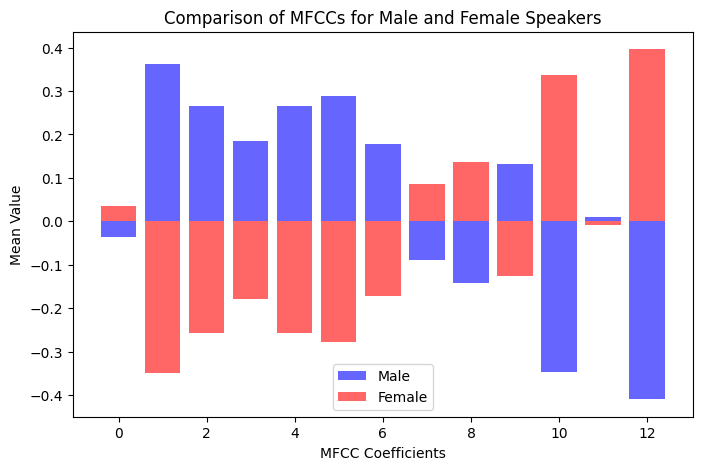

In [14]:
# Plot MFCCs
features = range(13)
plt.figure(figsize=(8, 5))
plt.bar(features, np.mean(male_mfcc_norm, axis=0), alpha=0.6, label="Male", color="blue")
plt.bar(features, np.mean(female_mfcc_norm, axis=0), alpha=0.6, label="Female", color="red")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Mean Value")
plt.title("Comparison of MFCCs for Male and Female Speakers")
plt.legend()
plt.show()

### Gender Classification

#### 1. Train Test Split (Cross-subject)

There are several methods for splitting data in a gender classification task. In this study, we use a cross-subject split, ensuring that no subjects overlap between the training and test sets. This approach guarantees a fair evaluation by preventing data leakage, thereby improving generalization and ensuring the model learns speaker-independent gender characteristics rather than memorizing individual voices.

We split the data into training, validation, and test sets using the ratio (0.6, 0.2, 0.2).

In [23]:
train_test_split = 0.6

random.seed(0) # for reproducibility
all_subjects = info['speaker_id'].unique().tolist()
random.shuffle(all_subjects)
random.seed()

train_subjects = all_subjects[:int(train_test_split * len(all_subjects))]
test_subjects = all_subjects[int(train_test_split * len(all_subjects)):]
# further split to test into test and validation
val_subjects = test_subjects[:int(0.5 * len(test_subjects))]
test_subjects = test_subjects[int(0.5 * len(test_subjects)):]

In [24]:
metadata_path = "./data/task1_metadata.json"

if not os.path.exists(metadata_path):
    metadata = {
        "train": train_subjects,
        "val": val_subjects,
        "test": test_subjects,
    }

    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=4)

else:
    print("metadata already exists")
    with open (metadata_path, "r") as f:
        metadata = json.load(f)

metadata already exists


In [25]:
train_df = info[info['speaker_id'].isin(train_subjects)]
val_df = info[info['speaker_id'].isin(val_subjects)]
test_df = info[info['speaker_id'].isin(test_subjects)]

print("Number of train subjects: {} | # male: {} | # female: {}".format(len(train_subjects), len(train_df[train_df['sex'] == 'M']['speaker_id'].unique()), len(train_df[train_df['sex'] == 'F']['speaker_id'].unique())))
print("Number of validation subjects: {} | # male: {} | # female: {}".format(len(val_subjects), len(val_df[val_df['sex'] == 'M']['speaker_id'].unique()), len(val_df[val_df['sex'] == 'F']['speaker_id'].unique())))
print("Number of test subjects: {} | # male: {} | # female: {}".format(len(test_subjects), len(test_df[test_df['sex'] == 'M']['speaker_id'].unique()), len(test_df[test_df['sex'] == 'F']['speaker_id'].unique())))

Number of train subjects: 24 | # male: 11 | # female: 13
Number of validation subjects: 8 | # male: 4 | # female: 4
Number of test subjects: 8 | # male: 5 | # female: 3


#### 2. Classifiers

### 2.1 Logistic Regression

Since there is a significant difference in the mean MFCC values between genders, we can design a logistic regression model that uses the average MFCCs as input features for classification.

In [38]:
train_data = avg_mfcc_df[avg_mfcc_df['speaker_id'].isin(train_subjects + val_subjects)]
test_data = avg_mfcc_df[avg_mfcc_df['speaker_id'].isin(test_subjects)]

In [39]:
from sklearn.linear_model import LogisticRegression

class LRModel():
    def __init__(self, scaler=None):
        self.scaler = scaler
        self.model = LogisticRegression()

    def fit(self, X, y):
        if self.scaler:
            X = self.scaler.transform(X)
        self.model.fit(X, y)

    def predict(self, X):
        if self.scaler:
            X = self.scaler.transform(X)
        return self.model.predict(X)

In [ ]:
scaler = StandardScaler()
scaler.fit(train_data['mfccs'].values.tolist())

lr_model = LRModel(scaler)
lr_model.fit(train_data['mfccs'].values.tolist(), train_data['gender_labels'].values)

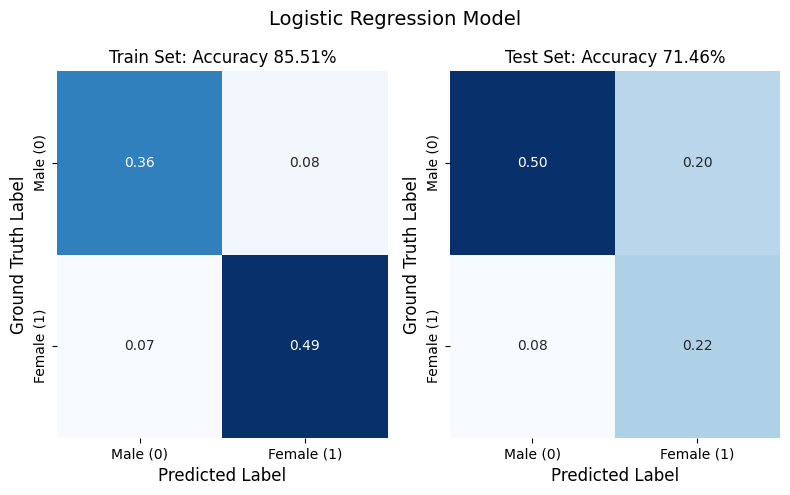

In [72]:
# test on test data
import seaborn as sns
from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Loop over train and test data
for i, (data_type, data) in enumerate(zip(['Train', 'Test'], [train_data, test_data])):
    # Predict labels
    logits = lr_model.predict(data['mfccs'].values.tolist())
    result = pd.DataFrame({'Predicted': logits, 'Ground Truth': data['gender_labels'].values.tolist()})

    # Compute confusion matrix (normalized per row)
    cm = confusion_matrix(result['Ground Truth'], result['Predicted'])
    cm = cm / cm.sum()

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"{data_type} Set: Accuracy {cm.trace() * 100:.2f}%")
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('Ground Truth Label', fontsize=12)
    axes[i].set_xticklabels(['Male (0)', 'Female (1)'], fontsize=10)
    axes[i].set_yticklabels(['Male (0)', 'Female (1)'], fontsize=10)

fig.suptitle("Logistic Regression Model", fontsize=14)
plt.tight_layout()
plt.show()

### 2.2 Support Vector Classifier

In [86]:
from sklearn.svm import SVC

class SVMModel():
    def __init__(self, scaler=None):
        self.scaler = scaler
        self.model = SVC()

    def fit(self, X, y):
        if self.scaler:
            X = self.scaler.transform(X)
        self.model.fit(X, y)

    def predict(self, X):
        if self.scaler:
            X = self.scaler.transform(X)
        return self.model.predict(X)

In [87]:
train_data = avg_mfcc_df[avg_mfcc_df['speaker_id'].isin(train_subjects + val_subjects)]
test_data = avg_mfcc_df[avg_mfcc_df['speaker_id'].isin(test_subjects)]

scaler = StandardScaler()
scaler.fit(train_data['mfccs'].values.tolist())

svc_model = SVMModel(scaler)
svc_model.fit(train_data['mfccs'].values.tolist(), train_data['gender_labels'].values)

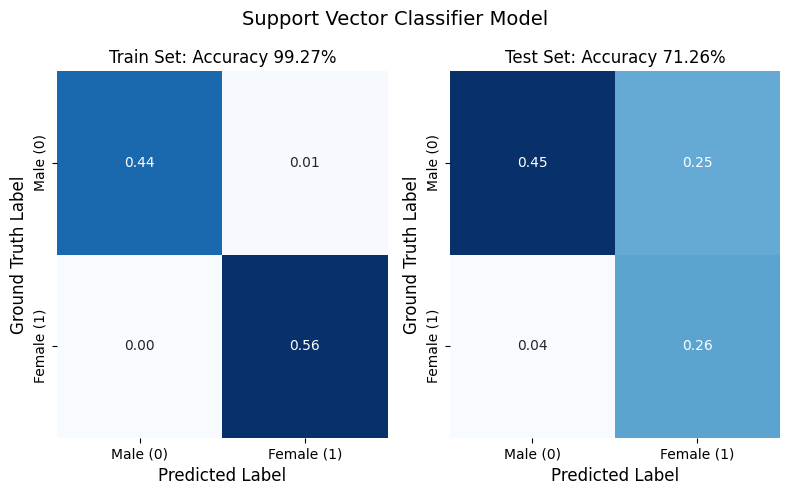

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Loop over train and test data
for i, (data_type, data) in enumerate(zip(['Train', 'Test'], [train_data, test_data])):
    # Predict labels
    logits = svc_model.predict(data['mfccs'].values.tolist())
    result = pd.DataFrame({'Predicted': logits, 'Ground Truth': data['gender_labels'].values.tolist()})

    # Compute confusion matrix (normalized per row)
    cm = confusion_matrix(result['Ground Truth'], result['Predicted'])
    cm = cm / cm.sum()

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"{data_type} Set: Accuracy {cm.trace() * 100:.2f}%")
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('Ground Truth Label', fontsize=12)
    axes[i].set_xticklabels(['Male (0)', 'Female (1)'], fontsize=10)
    axes[i].set_yticklabels(['Male (0)', 'Female (1)'], fontsize=10)

fig.suptitle("Support Vector Classifier Model", fontsize=14)
plt.tight_layout()
plt.show()

### 2.3 CNN Method

Previous naïve machine learning methods achieved an accuracy of approximately 71%. In this section, we explore deep learning approaches to determine whether they can improve classification performance while also reducing overfitting.

Instead of using the average MFCC across the entire audio period, we leverage all MFCC frames to preserve temporal dynamics. However, since each audio sample has a variable length, we define a maximum length constraint, ensuring that all audio inputs are fixed-size for both training and testing.

In a CNN-based approach, we treat MFCCs as 2D feature representations, similar to images, allowing the network to learn spatial patterns in the frequency-time domain.

### 2.4 RNN Method

TODO